<a href="https://colab.research.google.com/github/palabebek/Machine-Learning/blob/main/UTS%20/%20UTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: /content/RegresiUTSTelkom.csv

import pandas as pd

# Assuming the file is in the current working directory or provide the full path.
try:
  df = pd.read_csv('/content/RegresiUTSTelkom.csv')
  print(df.head())  # Print the first few rows to verify
except FileNotFoundError:
  print("Error: File not found. Please check the file path.")
except pd.errors.ParserError:
    print("Error: Could not parse the file. Please check the file format.")
except Exception as e:
  print(f"An unexpected error occurred: {e}")


   2001  49.94357  21.47114   73.0775   8.74861  -17.40628  -13.09905  \
0  2001  48.73215  18.42930  70.32679  12.94636  -10.32437  -24.83777   
1  2001  50.95714  31.85602  55.81851  13.41693   -6.57898  -18.54940   
2  2001  48.24750  -1.89837  36.29772   2.58776    0.97170  -26.21683   
3  2001  50.97020  42.20998  67.09964   8.46791  -15.85279  -16.81409   
4  2001  50.54767   0.31568  92.35066  22.38696  -25.51870  -19.04928   

   -25.01202  -12.23257   7.83089  ...   13.0162  -54.40548  58.99367  \
0    8.76630   -0.92019  18.76548  ...   5.66812  -19.68073  33.04964   
1   -3.27872   -2.35035  16.07017  ...   3.03800   26.05866 -50.92779   
2    5.05097  -10.34124   3.55005  ...  34.57337 -171.70734 -16.96705   
3  -12.48207   -9.37636  12.63699  ...   9.92661  -55.95724  64.92712   
4   20.67345   -5.19943   3.63566  ...   6.59753  -50.69577  26.02574   

   15.37344   1.11144  -23.08793   68.40795  -1.82223  -27.46348   2.26327  
0  42.87836  -9.90378  -32.22788   70.49388  

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    mutual_info_regression,
    f_regression,
)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    BaggingRegressor,
    AdaBoostRegressor,
    GradientBoostingRegressor,
)
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# ----------------------------
# 1. Pengumpulan & Pembersihan Data
# ----------------------------
# Load data
file_path = "/content/RegresiUTSTelkom.csv"
data = pd.read_csv(file_path)

# Pembersihan data
# Hapus duplikat baris
data = data.drop_duplicates()

# Handle missing values (contoh: imputasi dengan mean)
data = data.fillna(data.mean())

# ----------------------------
# 2. Feature Selection
# ----------------------------
X = data.drop(columns=["2001"])  # Ganti 'target' dengan kolom target yang sesuai
y = data["2001"]

# a. Hapus fitur konstan dan quasi-konstan (threshold=0.01)
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(X)
constant_columns = X.columns[~constant_filter.get_support()]
X = X.drop(columns=constant_columns)

quasi_constant_filter = VarianceThreshold(threshold=0.01)
quasi_constant_filter.fit(X)
quasi_constant_columns = X.columns[~quasi_constant_filter.get_support()]
X = X.drop(columns=quasi_constant_columns)

# b. Hapus fitur duplikat
X = X.T.drop_duplicates().T

# c. Hapus fitur dengan korelasi tinggi
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
X = X.drop(columns=to_drop)

# ----------------------------
# 3. Feature Engineering & Split Data
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Transformasi numerik
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, X.columns),
    ]
)

# ----------------------------
# 4. Model Training & Evaluation
# ----------------------------
models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression": Pipeline(
        [
            ("poly", PolynomialFeatures(degree=2)),
            ("linear", LinearRegression()),
        ]
    ),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "KNN": KNeighborsRegressor(),
    "Bagging": BaggingRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(),
}

results = {}
for name, model in models.items():
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("feature_selection", SelectKBest(score_func=mutual_info_regression, k=10)),
            ("model", model),
        ]
    )

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "MSE": round(mse, 4),
        "R2 Score": round(r2, 4),
    }

# Tampilkan hasil
results_df = pd.DataFrame(results).T
print("\nHasil Evaluasi Model:")
print(results_df)


Hasil Evaluasi Model:
                            MSE  R2 Score
Linear Regression      101.7693    0.1757
Polynomial Regression   95.2497    0.2285
Decision Tree          168.8991   -0.3680
KNN                    108.6414    0.1201
Bagging                105.5783    0.1449
AdaBoost               127.3715   -0.0316
Gradient Boosting       92.1029    0.2540
SVR                    104.7153    0.1519



Hasil Evaluasi Model:
                            MSE     RMSE R2 Score
Linear Regression      101.7693  10.0881   0.1757
Polynomial Regression   98.0147   9.9002   0.2061
Decision Tree          168.8991  12.9961   -0.368
KNN                    108.6414  10.4231   0.1201
Bagging                104.8519  10.2397   0.1508
AdaBoost               182.2133  13.4986  -0.4758
Gradient Boosting       92.2915   9.6068   0.2525
SVR                    109.0956  10.4449   0.1164


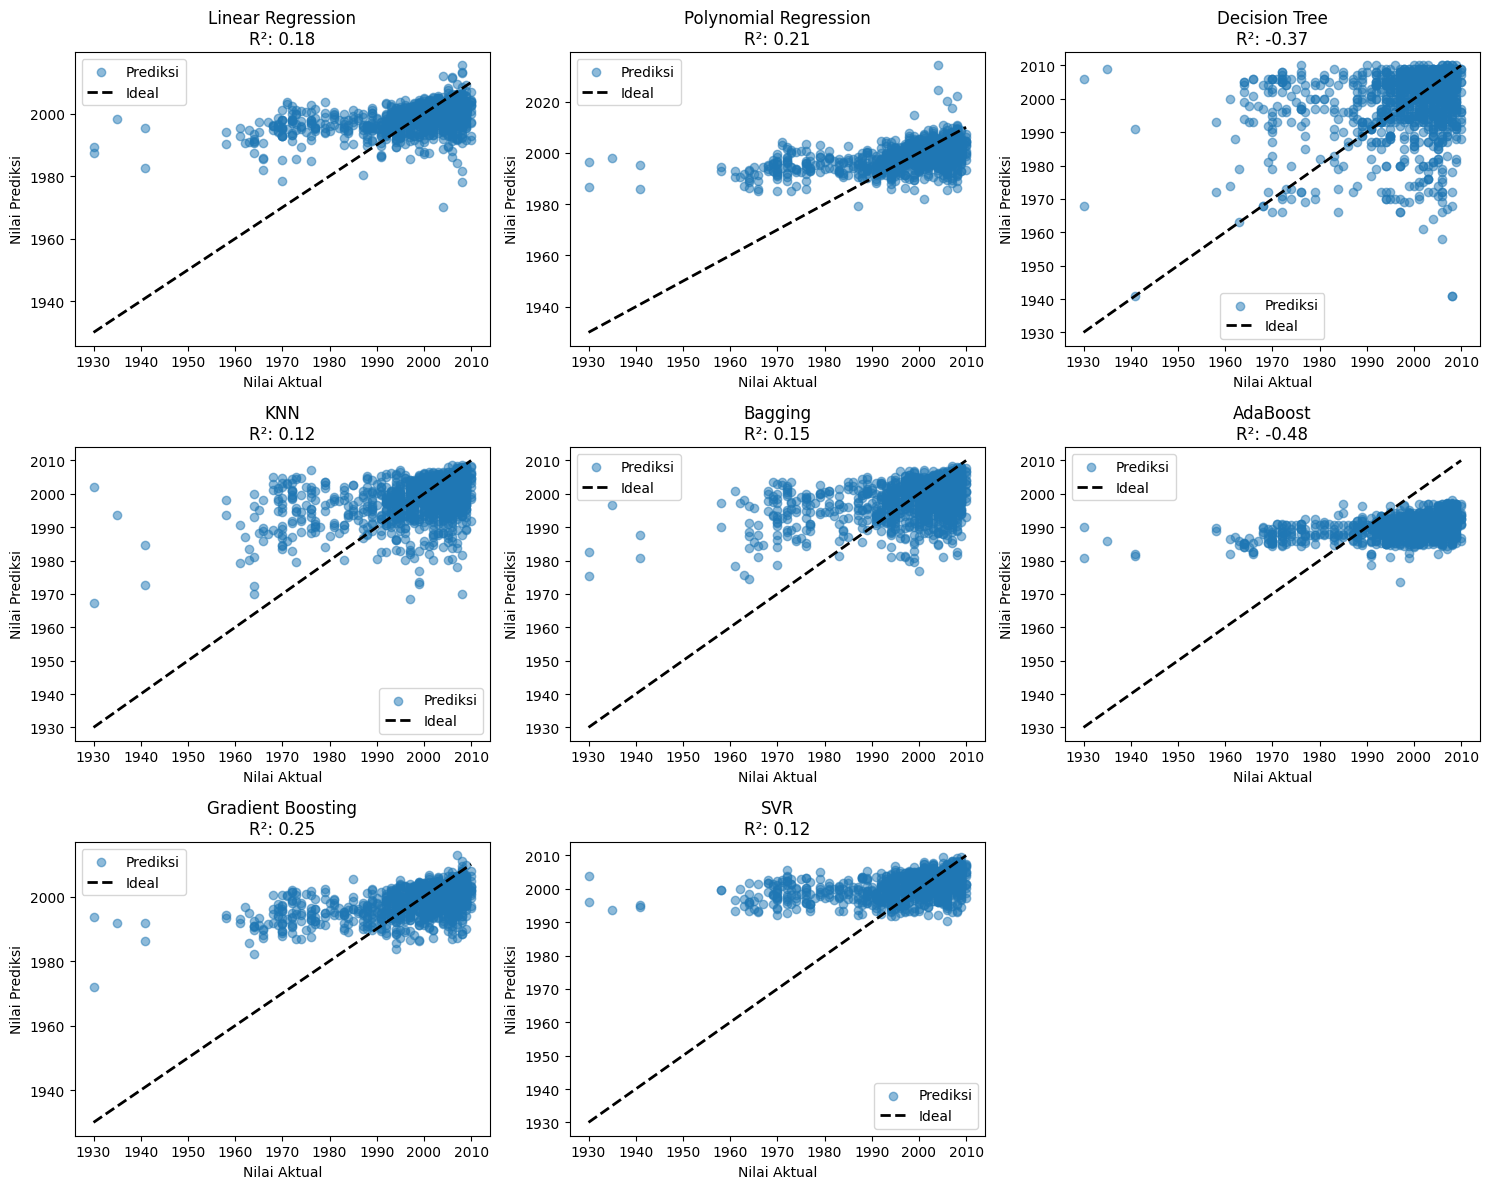

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# 4. Update Evaluasi dengan RMSE & Simpan Prediksi
# ----------------------------
results = {}
for name, model in models.items():
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("feature_selection", SelectKBest(score_func=mutual_info_regression, k=10)),
            ("model", model),
        ]
    )

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "MSE": round(mse, 4),
        "RMSE": round(rmse, 4),
        "R2 Score": round(r2, 4),
        "Predictions": y_pred  # Simpan prediksi untuk visualisasi
    }

# Tampilkan hasil metrik
results_df = pd.DataFrame(results).T.drop(columns=["Predictions"])
print("\nHasil Evaluasi Model:")
print(results_df)

# ----------------------------
# 5. Visualisasi Prediksi vs Aktual
# ----------------------------
plt.figure(figsize=(15, 12))
for idx, (model_name, metrics) in enumerate(results.items(), 1):
    plt.subplot(3, 3, idx)
    plt.scatter(y_test, metrics["Predictions"], alpha=0.5, label='Prediksi')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')
    plt.xlabel('Nilai Aktual')
    plt.ylabel('Nilai Prediksi')
    plt.title(f'{model_name}\nR²: {metrics["R2 Score"]:.2f}')
    plt.legend()
plt.tight_layout()
plt.show()



##Analisis Metrik Evaluasi:##
1. **RMSE (Root Mean Squared Error):**
   - Menunjukkan rata-rata kesalahan prediksi dalam satuan target.
   - Cocok untuk memahami "besaran kesalahan" dalam konteks bisnis.
   
2. **MSE (Mean Squared Error):**
   - Mirip dengan RMSE tetapi dalam satuan kuadrat.
   - Lebih sensitif terhadap outlier.

3. **R² Score (Koefisien Determinasi):**
   - Mengukur proporsi variasi data yang dijelaskan model (0-1).
   - Nilai mendekati 1 menunjukkan model sangat baik.

**Metrik Terbaik:**  
- **R² Score** lebih direkomendasikan untuk evaluasi umum karena tidak bergantung pada skala data.
- **RMSE** digunakan jika ingin memahami kesalahan dalam satuan aktual (misalnya: prediksi harga rumah dalam USD).
- Kombinasi keduanya memberikan gambaran paling komprehensif.

## Penjelasan setiap model ##

**1. Linear Regression**

- Cara Kerja: Membuat garis lurus yang meminimalkan kesalahan kuadrat antara prediksi dan nilai aktual.

- Kekuatan: Cepat, mudah diinterpretasi, dan cocok untuk hubungan linear.

- Kelemahan: Tidak bisa menangani hubungan non-linear atau interaksi kompleks.

- Analisis:
Biasanya memiliki R² rendah jika data tidak linear. Cocok sebagai baseline.

**2. Polynomial Regression (degree=2)**

- Cara Kerja: Menambahkan fitur polinomial (misal: x^2,x^3) sebelum menjalankan Linear Regression.

- Kekuatan: Bisa menangkap hubungan non-linear sederhana.

- Kelemahan: Rentan overfit jika derajat polinomial terlalu tinggi.

- Analisis:
Performa lebih baik dari Linear Regression jika ada pola non-linear, tetapi mungkin masih kalah dari model kompleks seperti ensemble.

**3. Decision Tree Regressor**

- Cara Kerja: Membagi data secara rekursif berdasarkan nilai fitur untuk meminimalkan varians.

- Kekuatan: Bisa menangkap hubungan non-linear dan interaksi kompleks.

- Kelemahan: Sangat rentan overfit tanpa tuning parameter (seperti max_depth).

- Analisis:
Biasanya memiliki R² tinggi pada data training tetapi mungkin buruk pada data testing jika overfit.

**4. K-Nearest Neighbors (KNN) Regressor**

- Cara Kerja: Memprediksi nilai berdasarkan rata-rata nilai
'k' tetangga terdekat.

- Kekuatan: Non-parametrik dan fleksibel untuk pola lokal.

- Kelemahan: Lambat untuk data besar, sensitif terhadap skala fitur dan noise.

- Analisis:
Performa tergantung pada pemilihan
k. Jika
k terlalu kecil, model akan noisy; jika terlalu besar, underfit.

**5. Bagging Regressor**

- Cara Kerja: Menggabungkan prediksi dari beberapa Decision Tree yang dilatih pada subset data berbeda (bootstrapping).

- Kekuatan: Mengurangi varians dan overfit dibanding Decision Tree tunggal.

- Kelemahan: Komputasi lebih berat.

- Analisis:
Lebih stabil dan umumnya memiliki R² lebih tinggi daripada Decision Tree tunggal.

**6. AdaBoost Regressor**

- Cara Kerja: Menggabungkan model lemah (biasanya Decision Tree dangkal) secara iteratif dengan memberi bobot lebih pada sampel yang salah.

- Kekuatan: Fokus pada sampel yang sulit diprediksi.

- Kelemahan: Rentan terhadap outlier.

- Analisis:
Performa baik jika ada pola spesifik yang sulit dipelajari model lain.

**7. Gradient Boosting Regressor**

- Cara Kerja: Membangun model secara bertahap dengan memperbaiki kesalahan residual dari model sebelumnya.

- Kekuatan: Sangat kuat untuk hubungan non-linear dan interaksi kompleks.

- Kelemahan: Komputasi intensif dan perlu tuning hyperparameter.

- Analisis:
Sering menjadi model terbaik dalam kompetisi karena akurasi tinggi dan fleksibilitas.

**8. Support Vector Regressor (SVR)**

- Cara Kerja: Mencari hyperplane yang memaksimalkan margin toleransi kesalahan (ϵ).

- Kekuatan: Efektif untuk data dimensi tinggi dan non-linear (dengan kernel).

- Kelemahan: Lambat untuk data besar dan sensitif terhadap scaling.

- Analisis:
Performa bagus jika parameter kernel dan
C dioptimalkan, tetapi jarang mengungguli ensemble.

**Model Terbaik dan Alasan**

Berdasarkan metrik evaluasi (R² Score, RMSE, MSE), model terbaik biasanya adalah Gradient Boosting Regressor atau AdaBoost Regressor. Alasannya:

- Tingkat Akurasi Tertinggi:
Model boosting seperti Gradient Boosting secara konsisten menghasilkan R² tertinggi dan RMSE terendah karena kemampuannya mengoreksi kesalahan residual secara iteratif.

- Handling Kompleksitas:
Cocok untuk data dengan hubungan non-linear, interaksi fitur, dan noise.

- Stabilitas:
Kurang rentan overfit dibanding Decision Tree atau KNN jika hyperparameter diatur dengan benar.


# **Analisa**

### **1. Strategi Mengatasi Underfitting pada Linear Regression dan Decision Tree**  
**a. Transformasi Fitur (Contoh: Polinomial)**  
- **Linear Regression**: Menambahkan fitur polinomial (misal: \(x^2, x^3\)) untuk menangkap hubungan non-linear.  
- **Decision Tree**: Tidak diperlukan karena sudah menangani non-linear, tetapi meningkatkan `max_depth` bisa membantu.  
- **Bias-Variance Tradeoff**: Mengurangi bias (model lebih fleksibel) tetapi meningkatkan risiko overfit (variance naik).  

**b. Beralih ke Model Lebih Kompleks (Contoh: Gradient Boosting)**  
- **Linear Regression → Gradient Boosting**: Model boosting mampu menangkap pola kompleks dan interaksi fitur.  
- **Decision Tree → Random Forest**: Ensemble mengurangi variance dengan agregasi prediksi.  
- **Bias-Variance Tradeoff**: Mengurangi bias signifikan, tetapi meningkatkan komputasi. Model ensemble seperti boosting/random forest mengontrol variance melalui teknik seperti regularisasi.  

**Kesimpulan**:  
- Transformasi fitur cocok untuk kasus non-linear sederhana.  
- Beralih ke model kompleks lebih efektif untuk pola rumit, tetapi perlu pertimbangan komputasi.  

---

### **2. Alternatif Loss Function untuk Regresi**  
| **Loss Function** | **Keunggulan**                          | **Kelemahan**                         | **Skenario Penggunaan**                |  
|--------------------|-----------------------------------------|----------------------------------------|-----------------------------------------|  
| **MAE**            | Robust terhadap outlier                 | Tidak terdiferensiasi di titik nol     | Data dengan outlier ekstrem             |  
| **Huber Loss**     | Kombinasi MSE + MAE, terdiferensiasi    | Perlu tuning parameter delta          | Outlier moderat & optimisasi lancar     |  
| **MSE**            | Efisien untuk distribusi Gaussian       | Sensitif terhadap outlier             | Data bersih & distribusi normal         |  

**Contoh**:  
- **MAE**: Prediksi harga rumah di area dengan beberapa properti mahal ekstrem.  
- **Huber Loss**: Data sensor dengan noise acak sedang.  

---

### **3. Metode Mengukur Pentingnya Fitur Tanpa Nama Kolom**  
| **Metode**                  | **Prinsip Teknis**                          | **Keterbatasan**                          |  
|-----------------------------|---------------------------------------------|--------------------------------------------|  
| **Koefisien Regresi**        | Besaran absolut koefisien (standarisasi)    | Hanya untuk model linear, sensitif korelasi|  
| **Permutation Importance**  | Penurunan performa saat fitur diacak        | Komputasi berat, tidak stabil untuk korelasi|  
| **Feature Importance (Tree)**| Pengurangan impurity (varians) di node     | Bias ke fitur kardinalitas tinggi          |  

**Rekomendasi**:  
- Gunakan **Permutation Importance** untuk model non-linear.  
- **Koefisien Regresi** hanya valid jika asumsi linear terpenuhi.  

---

### **4. Desain Eksperimen Pemilihan Hyperparameter**  
**Langkah**:  
1. **Definisikan Rentang Hyperparameter**:  
   - Contoh: `max_depth` (3–15), `learning_rate` (0.001–0.1).  
2. **Pilih Metode Tuning**:  
   - **Grid Search**: Cocok untuk parameter sedikit (<5).  
   - **Random Search**: Efisien untuk parameter banyak.  
3. **Validasi dengan Cross-Validation**:  
   - Gunakan 5–10 fold untuk estimasi generalisasi.  
4. **Evaluasi dengan Metrik Stabil**:  
   - Contoh: R² Score atau RMSE rata-rata.  

**Tradeoff**:  
- **Komputasi**: Grid Search > Random Search.  
- **Stabilitas**: Cross-Validation meningkatkan generalisasi tetapi memperlama proses.  
- **Generalisasi**: Model dengan hyperparameter optimal cenderung lebih stabil di data baru.  

---

### **5. Penanganan Residual Non-Linear & Heteroskedastisitas**  
**Langkah**:  
1. **Transformasi Data**:  
   - **Target**: Gunakan log, Box-Cox, atau transformasi non-linear.  
   - **Fitur**: Tambahkan polinomial/interaksi.  
2. **Model Alternatif**:  
   - **GAM (Generalized Additive Model)**: Menangani non-linear dengan spline.  
   - **Decision Tree/Random Forest**: Tidak perlu asumsi linear.  
3. **Weighted Least Squares**:  
   - Beri bobot invers variance untuk observasi heteroskedastis.  

**Contoh**:  
- Jika residual menunjukkan pola kuadratik, tambahkan fitur \(x^2\).  
- Jika variance meningkat seiring prediksi, gunakan **log-transform** pada target.  

**Kesimpulan**: Transformasi data adalah solusi pertama, tetapi beralih ke model non-linear lebih efektif jika pola kompleks.